In [1]:
import pyccl as ccl
import numpy as np
import pylab as plt

In [2]:
# Cosmology definition - adjusted to match blast one
h0 = 0.6727 #0.67
Ob = 0.0492 #071330589849
Odm= 0.2664 #19039780521262
As = np.e**3.047/1e10
ns = 0.9645 #65

In [3]:
nofz = np.load("data/mynz.npy")
dndz = np.zeros((2,1000))
dndz[0,:] = nofz["z"]
dndz[1,:] = nofz["nz"]

In [4]:
# Cosmology
camb_params = {"camb": {"halofit_version": "takahashi"}}

cosmo = ccl.Cosmology(Omega_c=Odm, Omega_b=Ob, h=h0, A_s=As, n_s=ns, matter_power_spectrum='camb', extra_parameters=camb_params)

# Redshift-dependent functions
#z = np.linspace(0,1.2,1024)
z = np.linspace(0,5,1024)

# Redshift distributions
nz1 = np.interp(z,dndz[0],dndz[1]) #np.exp(-((z-0.5)/0.05)**2/2)
#nz2 = np.exp(-((z-0.65)/0.05)**2/2)

# Bias
#bz = 0.95/ccl|growth_factor(cosmo,1./(1+z))
bz = np.ones_like(z)

# Magnification bias
sz = np.zeros_like(z)
# Intrinsic alignment amplitude
#az = -0.004 * np.ones_like(z)

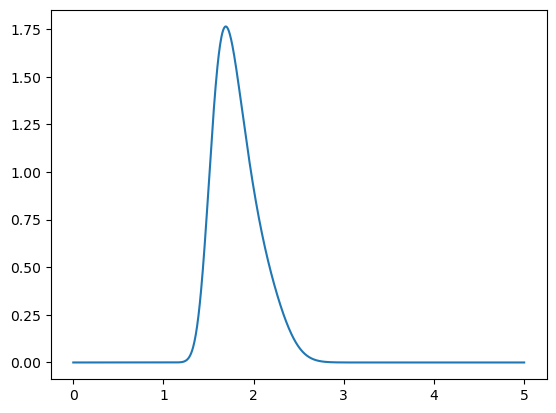

In [5]:
plt.plot(z, nz1)

In [6]:
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1089.)
cclg = ccl.NumberCountsTracer(cosmo,dndz=(z,nz1),bias=(z,bz),has_rsd=False)
ccls = ccl.tracers.WeakLensingTracer(cosmo, dndz=(z,nz1))

chi_finer = np.linspace(0,8000, 2000)
np.savez("data/ccl_cmb_kernel_finer.npz", cmbl.get_kernel(chi_finer)[0,:])
np.savez("data/ccl_gal_kernel_finer.npz", cclg.get_kernel(chi_finer)[0,:])
np.savez("data/ccl_sh_kernel_finer.npz", ccls.get_kernel(chi_finer)[0,:])
np.savez("data/chi_finer.npz", chi_finer)

In [7]:
ell_list = np.load("data/ell_list.npy")
blast_gg = np.load("blast_cls/D_gg.npy")
blast_ss = np.load("blast_cls/D_ss.npy")
blast_gs = np.load("blast_cls/D_gs.npy")
blast_gcmbl = np.load("blast_cls/D_gcmbl.npy")
blast_scmbl = np.load("blast_cls/D_scmbl.npy")

In [8]:
ccells = np.linspace(2, 2000, 800)

In [9]:
cl_gg_ccl = ccl.angular_cl(cosmo, cclg, cclg, ccells, l_limber=200, return_meta=True)[0]
cl_ss_ccl = ccl.angular_cl(cosmo, ccls, ccls, ccells, l_limber=200, return_meta=True)[0]
cl_gs_ccl = ccl.angular_cl(cosmo, cclg, ccls, ccells, l_limber=200, return_meta=True)[0]
cl_kg_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=200, return_meta=True)[0]
cl_ks_ccl = ccl.angular_cl(cosmo, cmbl, cclg, ccells, l_limber=200, return_meta=True)[0]

Text(0.5, 1.0, 'galaxy-galaxy')

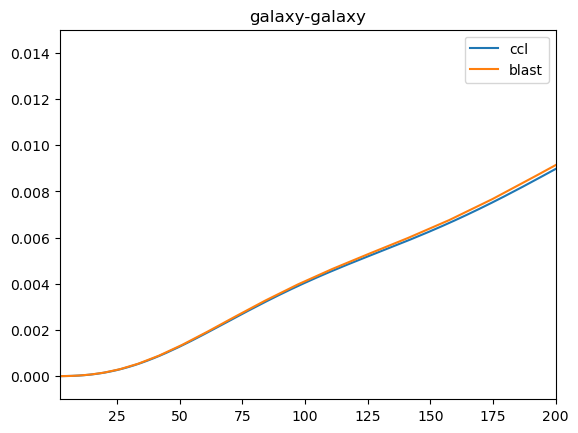

In [10]:
plt.plot(ccells, ccells * (ccells +1) * cl_gg_ccl, label="ccl" )
plt.plot(ell_list, blast_gg, label="blast")
plt.xlim((2,200))
plt.ylim((-1e-3,0.015))
plt.legend()
plt.title("galaxy-galaxy")

plt.plot(ell_list, 100 * (1 -  blast_gg/(cl_gg_ccl*ell_list * (ell_list +1) )))

Text(0.5, 1.0, 'shear-shear')

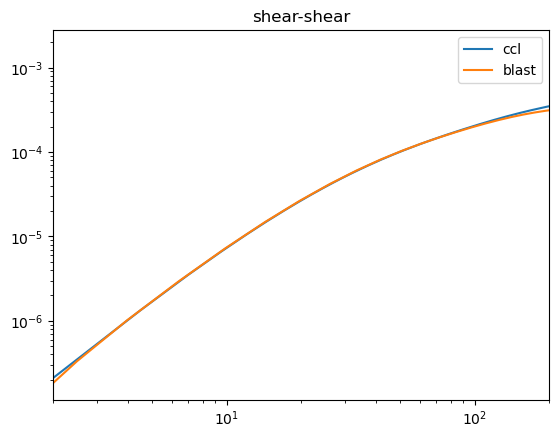

In [11]:
plt.loglog(ccells, ccells * (ccells +1) * cl_ss_ccl, label="ccl" )
plt.loglog(ell_list, blast_ss, label="blast")
plt.xlim(2,200)
plt.legend()
plt.title("shear-shear")

Text(0.5, 1.0, 'galaxy-galaxy lensing')

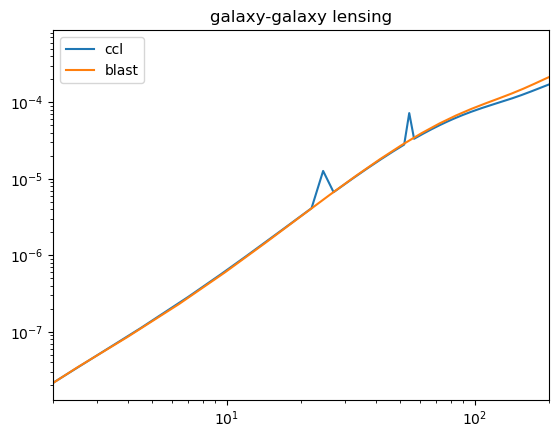

In [12]:
plt.loglog(ccells, ccells * (ccells +1) * cl_gs_ccl, label="ccl" )
plt.loglog(ell_list, blast_gs, label="blast")
plt.legend()
plt.xlim((2,200))
plt.title("galaxy-galaxy lensing")

Text(0.5, 1.0, 'galaxy-cmb lensing')

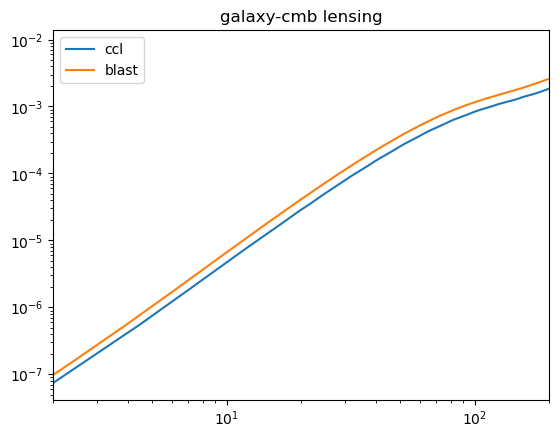

In [13]:
plt.loglog(ccells, (ccells * (ccells +1)) * cl_kg_ccl, label="ccl" )
plt.loglog(ell_list, blast_gcmbl, label="blast")
plt.legend()
plt.xlim((2,200))
plt.title("galaxy-cmb lensing")

In [14]:
new_ccl_kg = np.interp(ell_list, ccells, cl_kg_ccl)

Text(0.5, 1.0, 'shear-cmb lensing')

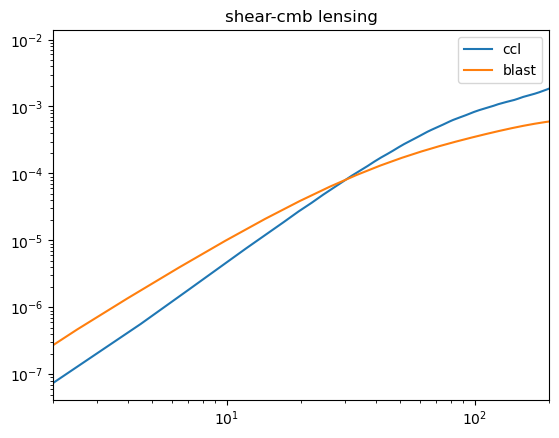

In [15]:
plt.loglog(ccells, ccells * (ccells +1) * cl_ks_ccl, label="ccl" )
plt.loglog(ell_list, blast_scmbl, label="blast")
plt.legend()
plt.xlim((2,200))
plt.title("shear-cmb lensing")

plt.plot(ell_list, 100 * (1 -  blast_scmbl/(cl_ks_ccl*ell_list * (ell_list +1) )))

### Power spectrum test

In [16]:
ccl_lin_pk = cosmo.get_linear_power()
ccl_nl_pk = cosmo.get_nonlin_power()

In [17]:
k = np.load("data/k_nl.npz")["arr_0"]
z = np.load("data/z_nl.npz")["arr_0"]
a = 1/(1+z)

In [18]:
pk_nl_camb = np.load("data/camb_nl_pk.npz")["arr_0"]

In [19]:
pk_lin_camb = np.load("data/camb_lin_pk.npz")["arr_0"]

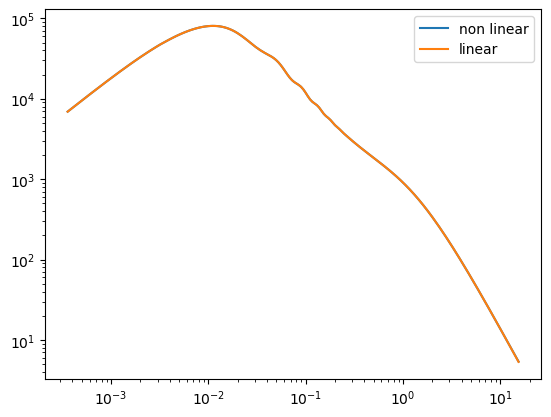

In [20]:
plt.loglog(k, ccl_nl_pk(k, a[0]), label = "non linear")
plt.loglog(k, pk_nl_camb[0,:], label = "linear")
plt.legend()

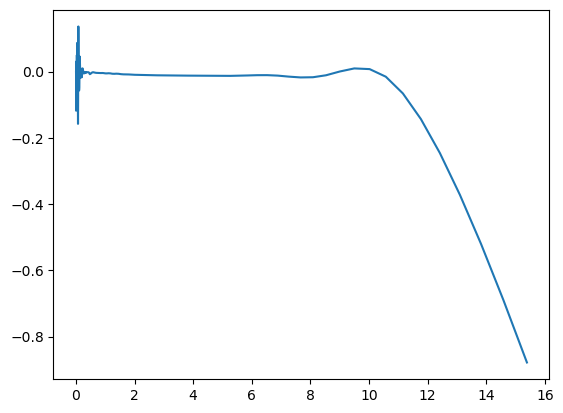

In [21]:
plt.plot(k, 100*(1-ccl_nl_pk(k, a[0])/pk_nl_camb[0,:]))